# OpenDrift

### Documentation

[https://github.com/opendrift/opendrift/wiki](https://github.com/opendrift/opendrift/wiki)

***

### Installation

`git clone https://github.com/OpenDrift/opendrift.git`

`python setup.py develop --user`

***

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from glob import glob
from datetime import datetime, timedelta
from dateutil.parser import parse
from itertools import repeat
from salishsea_tools import viz_tools
from rotate_fields_python import rotate_fields
from tqdm import tqdm_notebook as tqdm
from IPython.display import HTML

from opendrift.readers import reader_netCDF_CF_unstructured
from opendrift.models.oceandrift import OceanDrift

%matplotlib inline
plt.rcParams['font.size'] = 12
plt.rcParams['animation.html'] = 'html5'

***

### OceanDrift model

Required forcing

In [3]:
# OceanDrift require variables
OceanDrift.required_variables

['x_sea_water_velocity',
 'y_sea_water_velocity',
 'x_wind',
 'y_wind',
 'land_binary_mask']

***
### Prepare forcing files
Forcing must be gridded on lon/lat coordinates. The easiest way is to reshape everything onto a single spatial dimension and use `opendrift.readers.reader_netCDF_CF_unstructured`.

In [23]:
# Define paths
paths = {
    'NEMO': '/results/SalishSea/hindcast.201812',
    'NEMO_cutoff': '/results2/SalishSea/hindcast.201812_annex',
    'HRDPS': '/results/forcing/atmospheric/GEM2.5/operational',
    'coords': '/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc',
    'out': '/data/bmoorema/results/opendrift',
    'date_cutoff': '2016 Nov 21',
}
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
daterange = [parse(d) for d in ['2017 Nov 24', '2017 Nov 30']]

Prefix constructor for SalishSeaCast

In [5]:
def make_prefix(date, paths, res='h'):
    """Construct path prefix for local SalishSeaCast results given date object and paths dict
    e.g., /results/SalishSea/hindcast.201812/ddmmmyy/SalishSea_1h_yyyymmdd_yyyymmdd
    """

    path = paths['NEMO']
    if 'date_cutoff' in paths and date >= parse(paths['date_cutoff']):
        path = paths['NEMO_cutoff']
    fn = '_'.join([f'SalishSea_1{res}', *repeat(date.strftime('%Y%m%d'), 2)])
    prefix = os.path.join(path, date.strftime('%d%b%y').lower(), fn)
    
    return prefix

Process SalishSeaCast

In [6]:
def process_NEMO(date, paths, mask):
    """
    """

    prefix = make_prefix(date, paths)
    NEMO_out = os.path.join(paths['out'], 'forcing', os.path.split(prefix)[-1] + '_opendrift.nc')
    if os.path.exists(NEMO_out):
        print(f'{NEMO_out} already exists! Skipping ...')
        return
    else:
        print(f'Processing {NEMO_out}')
        raw = []
        for k, key in zip(['U', 'V'], ['vozocrtx', 'vomecrty']):
            with xr.open_dataset(prefix + f'_grid_{k}.nc') as data:
                raw.append(data[key][:, 0, ...].values)
                if k is 'U': time = data.time_counter
        u, v = viz_tools.rotate_vel2(*viz_tools.unstagger(*raw), paths['coords'])
        xr.Dataset(
            {
                'longitude': ('flat', mask.nav_lon[1:, 1:].values.reshape(-1)),
                'latitude': ('flat', mask.nav_lat[1:, 1:].values.reshape(-1)),
                'meshmask': ('flat', mask.tmask[0, 0, 1:, 1:].values.reshape(-1), {'standard_name': 'land_binary_mask'}),
                'u': (['time_counter', 'flat'], u.reshape(time.size, -1), {'standard_name': 'x_sea_water_velocity'}),
                'v': (['time_counter', 'flat'], v.reshape(time.size, -1), {'standard_name': 'y_sea_water_velocity'}),
            },
            coords={'time_counter': time}
        ).to_netcdf(NEMO_out)

Process HRDPS

In [7]:
def process_HRDPS(date, paths):
    """
    """

    datestr = date.strftime('ops_y%Ym%md%d.nc')
    HRDPS_out = os.path.join(paths['out'], 'forcing', datestr)
    if os.path.exists(HRDPS_out):
        print(f'{HRDPS_out} already exists! Skipping ...')
        return
    else:
        print(f'Processing {HRDPS_out}')
        with xr.open_dataset(os.path.join(paths['HRDPS'], datestr)) as data:
            time = data.time_counter
            time.attrs['standard_name'] = 'time'
            xr.Dataset(
                {
                    'longitude': ('flat', data.nav_lon.values.reshape(-1)),
                    'latitude': ('flat', data.nav_lat.values.reshape(-1)),
                    'u_wind': (['time_counter', 'flat'], data.u_wind.values.reshape(time.size, -1), {'standard_name': 'x_wind'}),
                    'v_wind': (['time_counter', 'flat'], data.v_wind.values.reshape(time.size, -1), {'standard_name': 'y_wind'}),
                },
                coords={'time_counter': time},
            ).to_netcdf(HRDPS_out)

Loop processing

In [24]:
# Date range
for day in tqdm(range(np.diff(daterange)[0].days + 1)):
    date = daterange[0] + timedelta(days=day)
    process_NEMO(date, paths, mask)
    process_HRDPS(date, paths)

Processing /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171124_20171124_opendrift.nc
Processing /data/bmoorema/results/opendrift/forcing/ops_y2017m11d24.nc
Processing /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171125_20171125_opendrift.nc
Processing /data/bmoorema/results/opendrift/forcing/ops_y2017m11d25.nc
Processing /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171126_20171126_opendrift.nc
Processing /data/bmoorema/results/opendrift/forcing/ops_y2017m11d26.nc
Processing /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171127_20171127_opendrift.nc
Processing /data/bmoorema/results/opendrift/forcing/ops_y2017m11d27.nc
Processing /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171128_20171128_opendrift.nc
Processing /data/bmoorema/results/opendrift/forcing/ops_y2017m11d28.nc
Processing /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171129_20171129_opendrift.nc
Processing /data/bmoorema/results/opendrift/forcing/ops_y2017m11d29.n

***

In [25]:
o = OceanDrift(loglevel=20)

14:36:30 INFO: OpenDriftSimulation initialised (version 1.0.6)


In [26]:
datestr = daterange[0].strftime('%Y%m')
o.add_readers_from_list(sorted(glob(os.path.join(paths['out'], 'forcing', f'SalishSea_1h_{datestr}*'))))

14:36:32 INFO: Setting SRS to latlong, since not defined before.


In [28]:
o.seed_elements(-123.5, 49.2, radius=500, number=100, time=daterange[0])

In [29]:
o.run(duration=np.diff(daterange)[0] + timedelta(days=1))

14:36:48 INFO: Config validation OK
14:36:48 INFO: Fallback values will be used for the following variables which have no readers: 
14:36:48 INFO: 	x_sea_water_velocity: 0.000000
14:36:48 INFO: 	y_sea_water_velocity: 0.000000
14:36:48 INFO: 	x_wind: 0.000000
14:36:48 INFO: 	y_wind: 0.000000
14:36:48 INFO: Adding a dynamical landmask (resolution "h") based on assumed maximum speed of 1 m/s. Adding a customised landmask may be faster...
14:36:57 INFO: Using existing reader for land_binary_mask
14:36:57 INFO: All points are in ocean
14:36:57 INFO: 2017-11-24 00:00:00 - step 1 of 168 - 100 active elements (0 deactivated)
14:36:57 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171124_20171124_opendrift.nc
14:36:57 INFO: Opening file with Dataset
14:36:57 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171125_20171125_opendrift.nc
14:36:57 INFO: Opening file with Dataset
14:36:58 INFO: Opening dataset: /data/bmoorema/results/open

Buffer length 0
Buffer length 0


14:36:58 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171127_20171127_opendrift.nc
14:36:58 INFO: Opening file with Dataset
14:36:58 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171128_20171128_opendrift.nc
14:36:58 INFO: Opening file with Dataset


Buffer length 0
Buffer length 0


14:36:58 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171129_20171129_opendrift.nc
14:36:58 INFO: Opening file with Dataset
14:36:58 INFO: Opening dataset: /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171130_20171130_opendrift.nc
14:36:58 INFO: Opening file with Dataset


Buffer length 0
Buffer length 0


14:36:58 INFO: 2017-11-24 01:00:00 - step 2 of 168 - 100 active elements (0 deactivated)


Buffer length 0


14:36:58 INFO: 2017-11-24 02:00:00 - step 3 of 168 - 100 active elements (0 deactivated)
14:36:59 INFO: 2017-11-24 03:00:00 - step 4 of 168 - 100 active elements (0 deactivated)
14:36:59 INFO: 2017-11-24 04:00:00 - step 5 of 168 - 100 active elements (0 deactivated)
14:36:59 INFO: 2017-11-24 05:00:00 - step 6 of 168 - 100 active elements (0 deactivated)
14:36:59 INFO: 2017-11-24 06:00:00 - step 7 of 168 - 100 active elements (0 deactivated)
14:36:59 INFO: 2017-11-24 07:00:00 - step 8 of 168 - 100 active elements (0 deactivated)
14:36:59 INFO: 2017-11-24 08:00:00 - step 9 of 168 - 100 active elements (0 deactivated)
14:36:59 INFO: 2017-11-24 09:00:00 - step 10 of 168 - 100 active elements (0 deactivated)
14:37:00 INFO: 2017-11-24 10:00:00 - step 11 of 168 - 100 active elements (0 deactivated)
14:37:00 INFO: 2017-11-24 11:00:00 - step 12 of 168 - 100 active elements (0 deactivated)
14:37:00 INFO: 2017-11-24 12:00:00 - step 13 of 168 - 100 active elements (0 deactivated)
14:37:00 INFO: 20

14:37:07 INFO: 2017-11-26 02:00:00 - step 51 of 168 - 91 active elements (9 deactivated)
14:37:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171126_20171126_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:08 INFO: 2017-11-26 03:00:00 - step 52 of 168 - 91 active elements (9 deactivated)
14:37:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171126_20171126_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:08 INFO: 2017-11-26 04:00:00 - step 53 of 168 - 91 active elements (9 deactivated)
14:37:08 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171126_20171126_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:08 INFO: 2017-11-26 05:00:00 - step 54 of 168 - 89 active elements (11 deactivated

14:37:13 INFO: 2017-11-27 06:00:00 - step 79 of 168 - 69 active elements (31 deactivated)
14:37:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171127_20171127_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:13 INFO: 2017-11-27 07:00:00 - step 80 of 168 - 69 active elements (31 deactivated)
14:37:13 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171127_20171127_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:13 INFO: 2017-11-27 08:00:00 - step 81 of 168 - 69 active elements (31 deactivated)
14:37:14 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171127_20171127_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:14 INFO: 2017-11-27 09:00:00 - step 82 of 168 - 69 active elements (31 deactiva

14:37:21 INFO: 2017-11-28 10:00:00 - step 107 of 168 - 55 active elements (45 deactivated)
14:37:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171128_20171128_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:21 INFO: 2017-11-28 11:00:00 - step 108 of 168 - 55 active elements (45 deactivated)
14:37:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171128_20171128_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:21 INFO: 2017-11-28 12:00:00 - step 109 of 168 - 54 active elements (46 deactivated)
14:37:21 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171128_20171128_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:21 INFO: 2017-11-28 13:00:00 - step 110 of 168 - 54 active elements (46 deac

14:37:27 INFO: 2017-11-29 14:00:00 - step 135 of 168 - 22 active elements (78 deactivated)
14:37:27 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171129_20171129_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:27 INFO: 2017-11-29 15:00:00 - step 136 of 168 - 22 active elements (78 deactivated)
14:37:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171129_20171129_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:28 INFO: 2017-11-29 16:00:00 - step 137 of 168 - 21 active elements (79 deactivated)
14:37:28 WARNING: Data block from /data/bmoorema/results/opendrift/forcing/SalishSea_1h_20171129_20171129_opendrift.nc not large enough to cover element positions within timestep. Buffer size (0) must be increased.
14:37:28 INFO: 2017-11-29 17:00:00 - step 138 of 168 - 20 active elements (80 deac

14:37:35 INFO: Zooming basemap to (-124.72276153564454 to -123.06195220947265 E), (48.99000244140625 to 49.76892013549805 N)


In [30]:
anim = o.animation()

In [31]:
HTML(anim.to_html5_video())

14:37:40 INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
14:37:40 INFO: figure size (inches) has been adjusted from 11.0 x 10.999080172284149 to 11.0 x 10.972222222222221
14:37:40 INFO: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '792x790', '-pix_fmt', 'rgba', '-r', '20.0', '-loglevel', 'quiet', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmp_jzamp5s/temp.m4v']


***

## Vector Rotation

From Hauke

In [23]:
o.add_reader([reader_NEMO, reader_HRDPS])

In [14]:
# Rotation from Hauke
prefix = make_prefix(date, paths)
fn_out = os.path.join(paths['out'], 'rotated_Hauke.nc')
r = rotate_fields()
r.rotate_fields(prefix + '_grid_U.nc', prefix + '_grid_V.nc', os.path.join(paths['out'], 'rotated_Hauke.nc'), 'SSC')

getting grid rotation coefficients
rotating
unstaggering
saving


In [24]:
o.seed_elements(-123.5, 49.2, radius=500, number=100, time=reader_NEMO.start_time, wind_drift_factor=0.03)

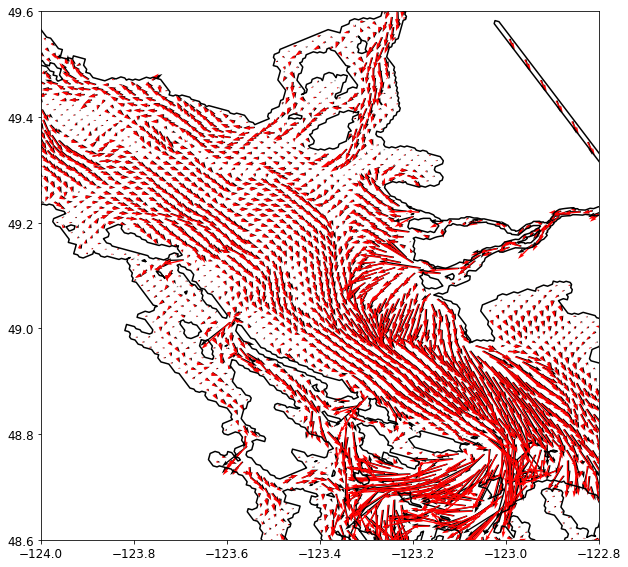

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlim([-124, -122.8])
ax.set_ylim([48.6, 49.6])
viz_tools.set_aspect(ax)
ax.contour(mask.nav_lon, mask.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
for fn, u_key, v_key, color in zip([fn_out, NEMO_out], ['x_sea_water_velocity', 'u'], ['y_sea_water_velocity', 'v'], ['k', 'r']):
    with xr.open_dataset(fn).isel(time_counter=0) as data:
        u = np.ma.masked_where(data.meshmask == 0, data[u_key])[::10]
        v = np.ma.masked_where(data.meshmask == 0, data[v_key])[::10]
        q = ax.quiver(data.longitude[::10], data.latitude[::10], u, v, scale=20, color=color)